# Stroke Prediction Analysis

This Jupyter Notebook contains the main code for the stroke prediction analysis project.

## Import necessary libraries

In [ ]:
import sys
print(sys.executable)  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import ADASYN
import os
import importlib

sys.path.append(os.path.abspath("d:/mybabie/ML-StrokePrediction/stroke-prediction-analysis"))

# Importing custom modules from the src directory
import src.data_loading
import src.data_cleaning
import src.data_analysis
import src.model_training
import src.model_evaluation
import src.model_interpretation

def reload_modules():
    importlib.reload(src.data_loading)
    importlib.reload(src.data_cleaning)
    importlib.reload(src.data_analysis)
    importlib.reload(src.model_training)
    importlib.reload(src.model_evaluation)
    importlib.reload(src.model_interpretation)

reload_modules()



d:\mybabie\ML-StrokePrediction\venv\Scripts\python.exe


## Load the Data 



In [157]:

data = load_data()
print(f"Number of rows in the dataset: {data.shape[0]}")
print(f"Number of columns in the dataset: {data.shape[1]}")
data.head()

Number of rows in the dataset: 5110
Number of columns in the dataset: 12


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Preprocessing Data and Exploratory Data Analysis



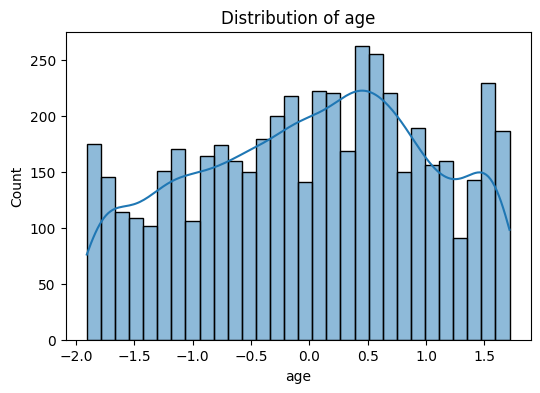

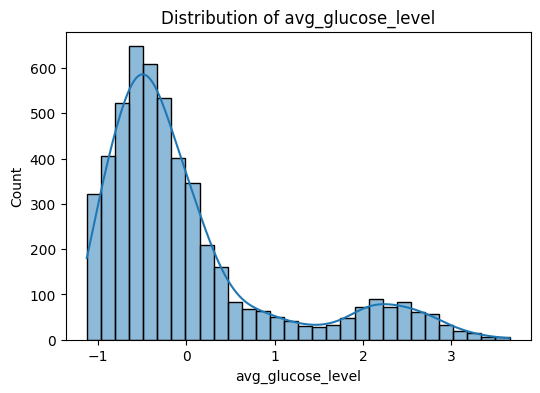

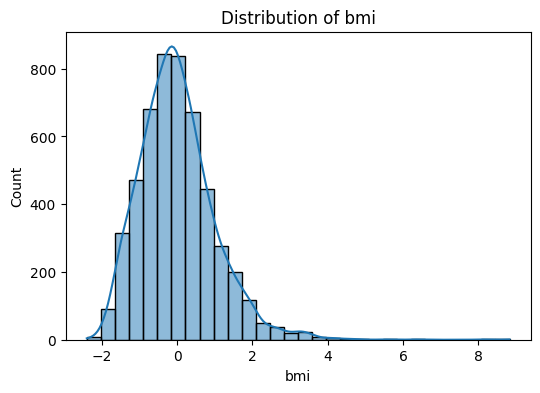

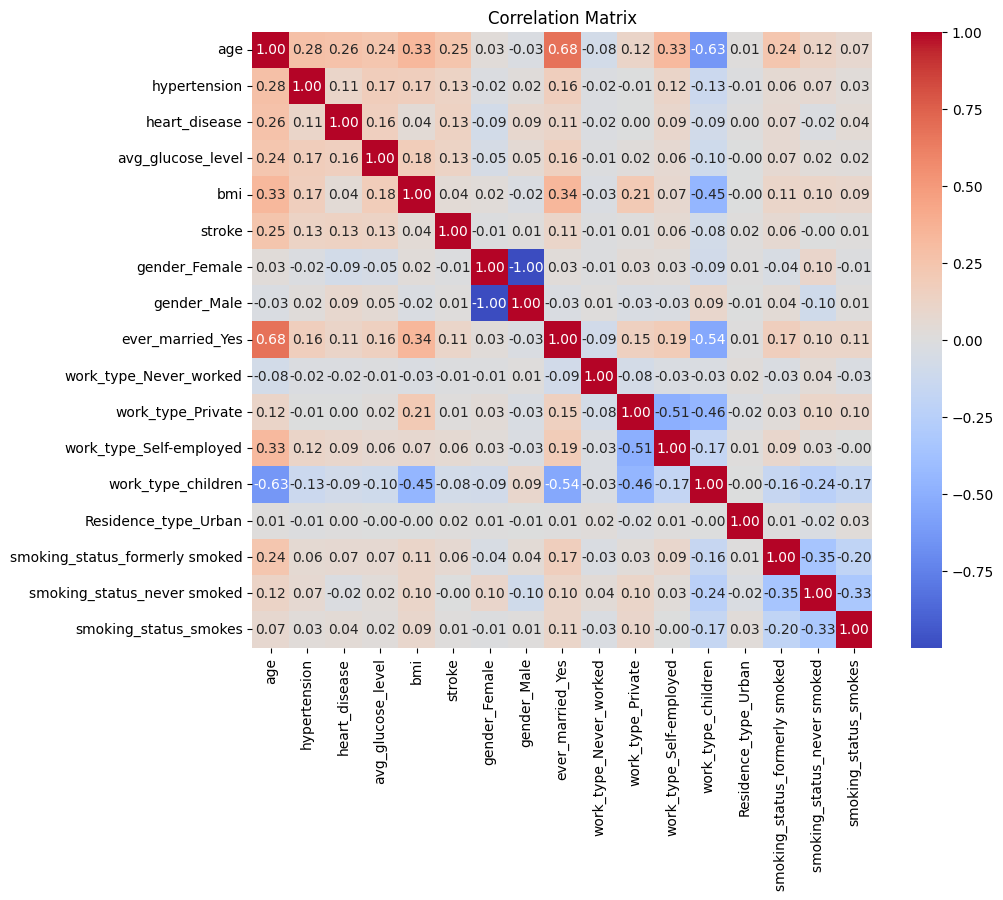

Categorical features: ['hypertension', 'heart_disease', 'gender_Female', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


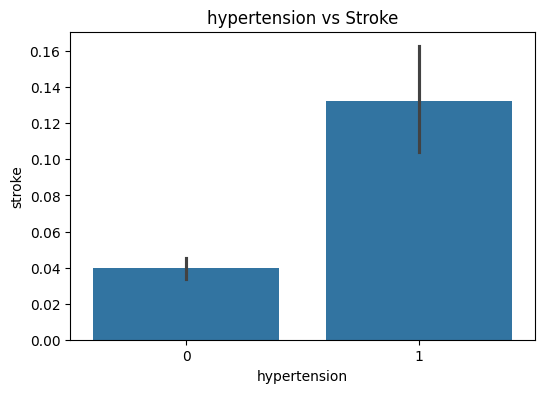

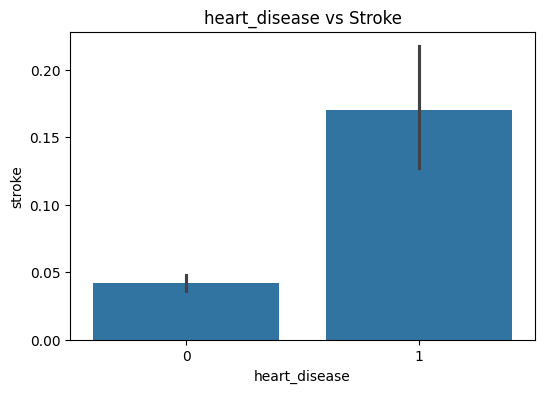

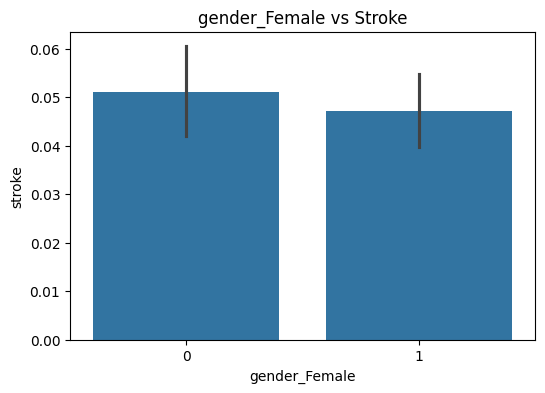

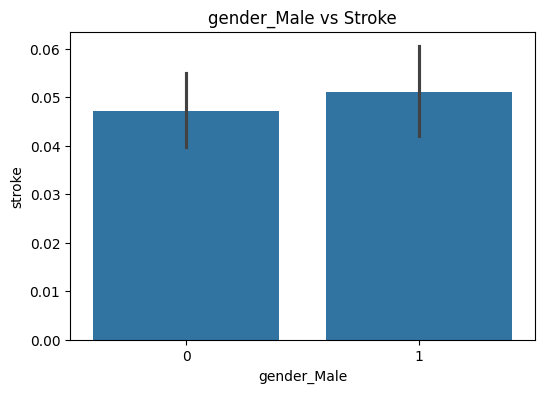

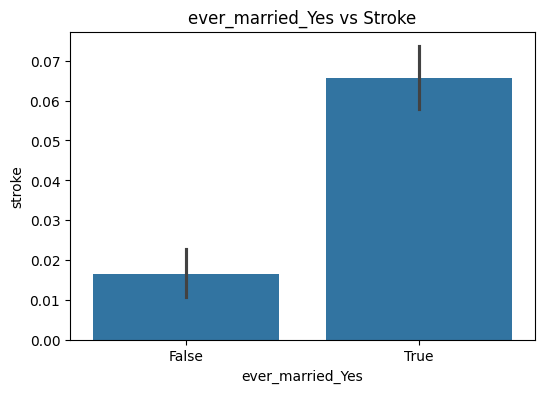

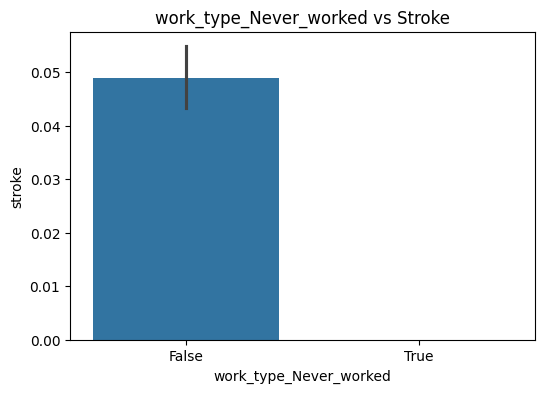

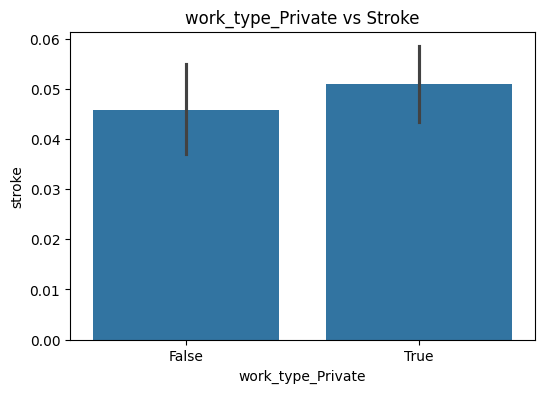

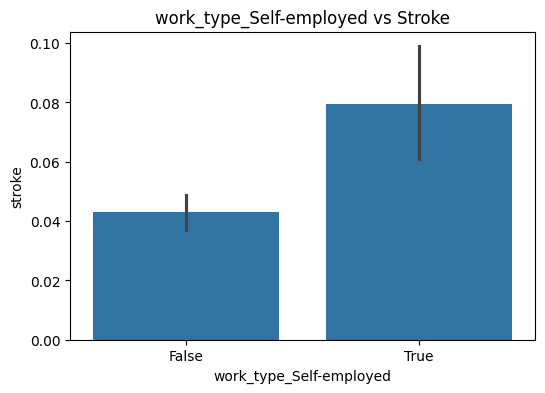

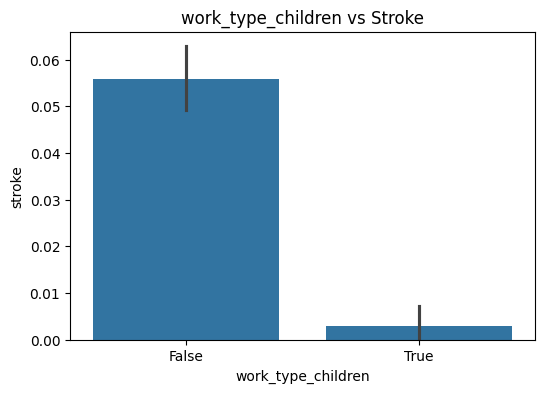

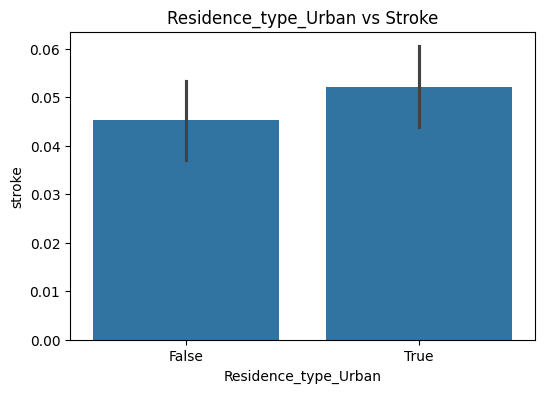

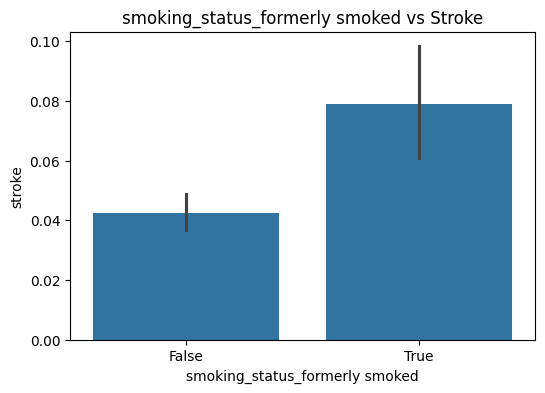

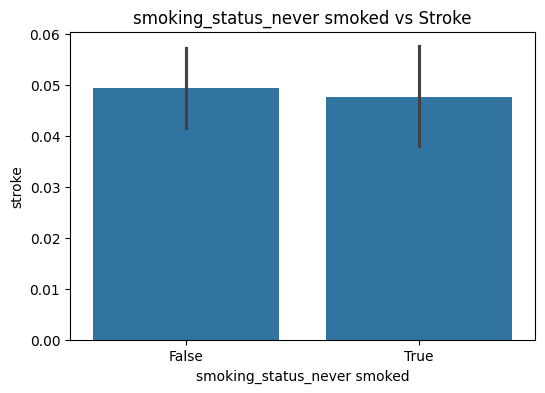

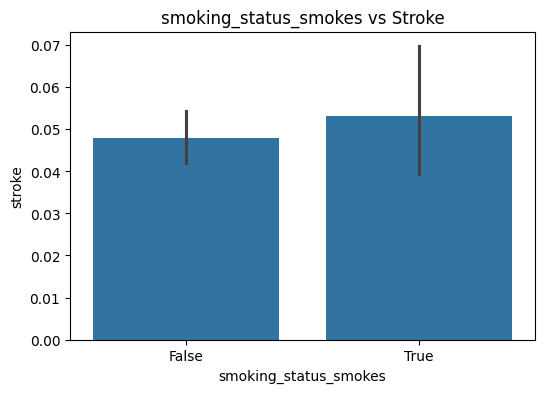

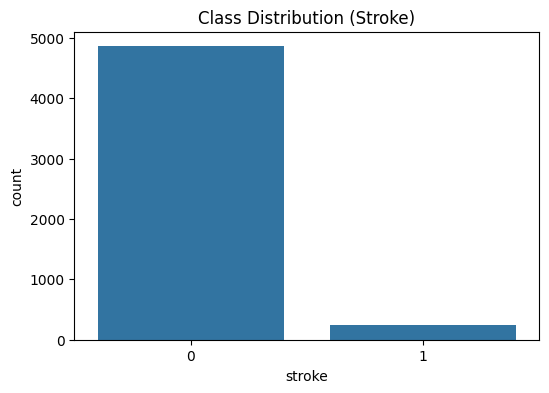

Number of rows: 5110
Number of columns: 17
High Risk Condition Feature Created
Scaled Data Sample:
        age  hypertension  heart_disease  avg_glucose_level       bmi  stroke  \
0  1.051434             0              1           2.706375  0.980817       1   
1  0.786070             0              0           2.121559  0.985836       1   
2  1.626390             0              1          -0.005028  0.453236       1   
3  0.255342             0              0           1.437358  0.697725       1   
4  1.582163             1              0           1.501184 -0.640530       1   

   gender_Female  gender_Male  ever_married_Yes  work_type_Never_worked  \
0              0            1              True                   False   
1              1            0              True                   False   
2              0            1              True                   False   
3              1            0              True                   False   
4              1            0          

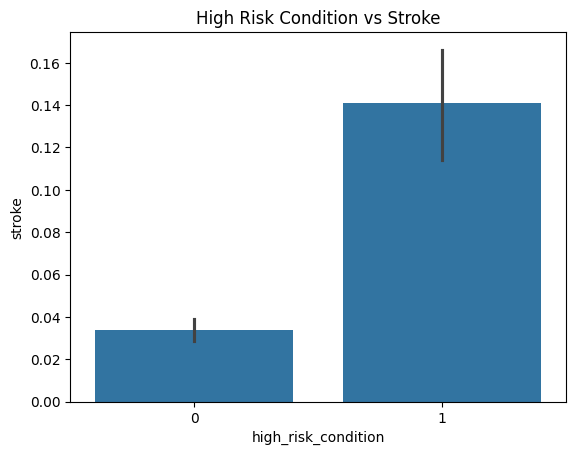

High Risk Condition Distribution:
high_risk_condition
0    4400
1     710
Name: count, dtype: int64


High Risk Condition Correlation with Stroke:
0.1718705408870232


Correlation with other features:
age                               0.365585
hypertension                      0.818026
heart_disease                     0.594838
avg_glucose_level                 0.219342
bmi                               0.162674
stroke                            0.171871
gender_Female                    -0.064319
gender_Male                       0.064483
ever_married_Yes                  0.200258
work_type_Never_worked           -0.159595
work_type_Private                -0.007329
work_type_Self-employed           0.148369
Residence_type_Urban             -0.003052
smoking_status_formerly smoked    0.079295
smoking_status_never smoked       0.042321
smoking_status_smokes             0.047559
high_risk_condition               1.000000
Name: high_risk_condition, dtype: float64


Rows before removing out

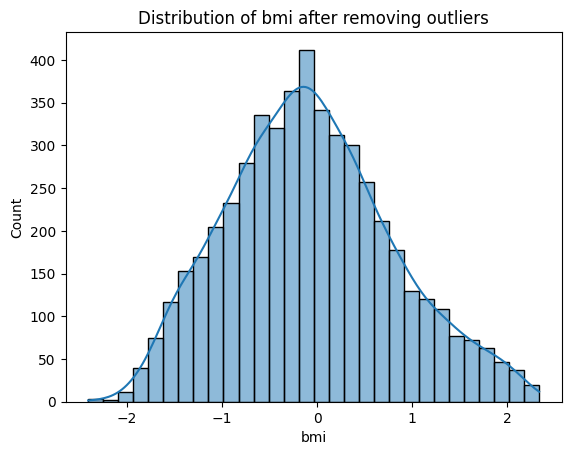

Remaining features after removal of low importance features: ['age', 'avg_glucose_level', 'bmi', 'stroke', 'ever_married_Yes', 'work_type_Private', 'work_type_Self-employed', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'high_risk_condition']
Cleaned data saved to ../data/processed/cleaned_data.csv


In [ ]:
import src.data_cleaning as data_cleaning
import os
import importlib
from src.data_cleaning import clean_data

cleaned_data = clean_data(data)
perform_eda(cleaned_data)
output_path = "../data/processed/cleaned_data.csv"
cleaned_data.to_csv(output_path, index=False)
print(f"Number of rows: {cleaned_data.shape[0]}")
print(f"Number of columns: {cleaned_data.shape[1]}")

cleaned_data['work_type_Never_worked'] += cleaned_data['work_type_children']

cleaned_data = cleaned_data.drop('work_type_children', axis=1)

# Adding a new feature 'high_risk_condition' based on heart disease and hypertension
cleaned_data['high_risk_condition'] = ((cleaned_data['heart_disease'] == 1) | (cleaned_data['hypertension'] == 1)).astype(int)

print("High Risk Condition Feature Created")
print("Scaled Data Sample:")
print(cleaned_data.head())
print(f"Columns in the dataset: {cleaned_data.columns.tolist()}")

sns.barplot(x='high_risk_condition', y='stroke', data=cleaned_data)
plt.title('High Risk Condition vs Stroke')
plt.show()

print("High Risk Condition Distribution:")
print(cleaned_data['high_risk_condition'].value_counts())
print("\n")
print("High Risk Condition Correlation with Stroke:")
print(cleaned_data.corr()['stroke']['high_risk_condition'])
print("\n")
print("Correlation with other features:")
print(cleaned_data.corr()['high_risk_condition'])
print("\n")

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1  

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    print(f"Rows before removing outliers: {df.shape[0]}")
    print(f"Rows after removing outliers: {filtered_df.shape[0]}")
    return filtered_df


cleaned_data = remove_outliers(cleaned_data, 'bmi')

sns.histplot(cleaned_data['bmi'], kde=True, bins=30)
plt.title('Distribution of bmi after removing outliers')
plt.show()

low_importance_features = ['heart_disease', 'work_type_Never_worked', 'gender_Male', 
                           'hypertension', 'smoking_status_smokes', 'gender_Female']

cleaned_data = cleaned_data.drop(columns=[col for col in low_importance_features if col in cleaned_data.columns])

print(f"Remaining features after removal of low importance features: {cleaned_data.columns.tolist()}")

cleaned_data.to_csv(output_path, index=False)
print(f"Cleaned data saved to {output_path}")

## Last data check before training

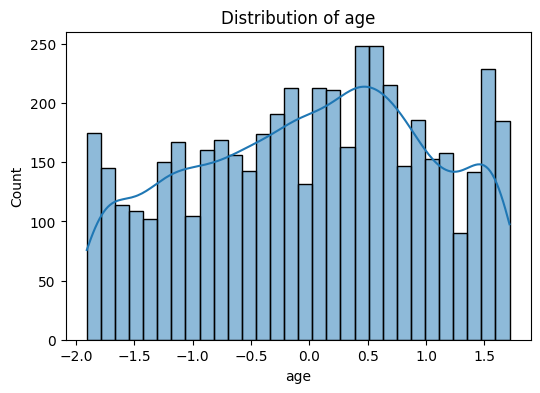

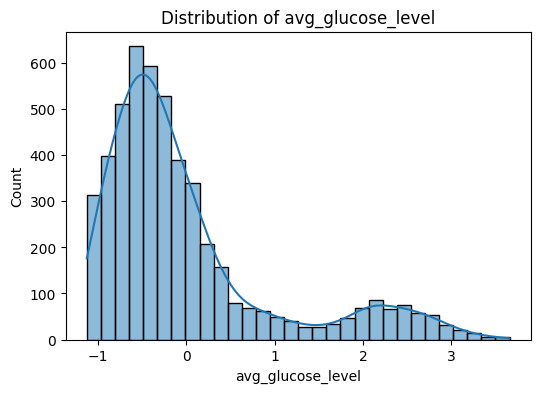

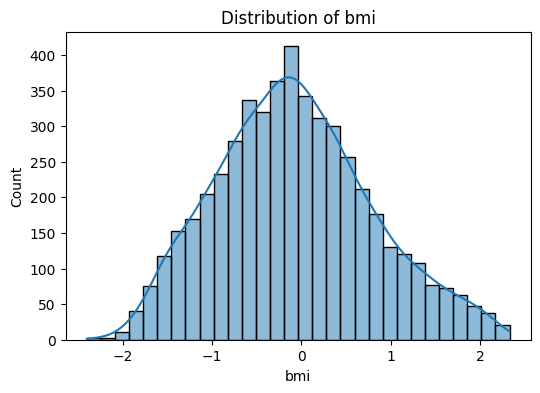

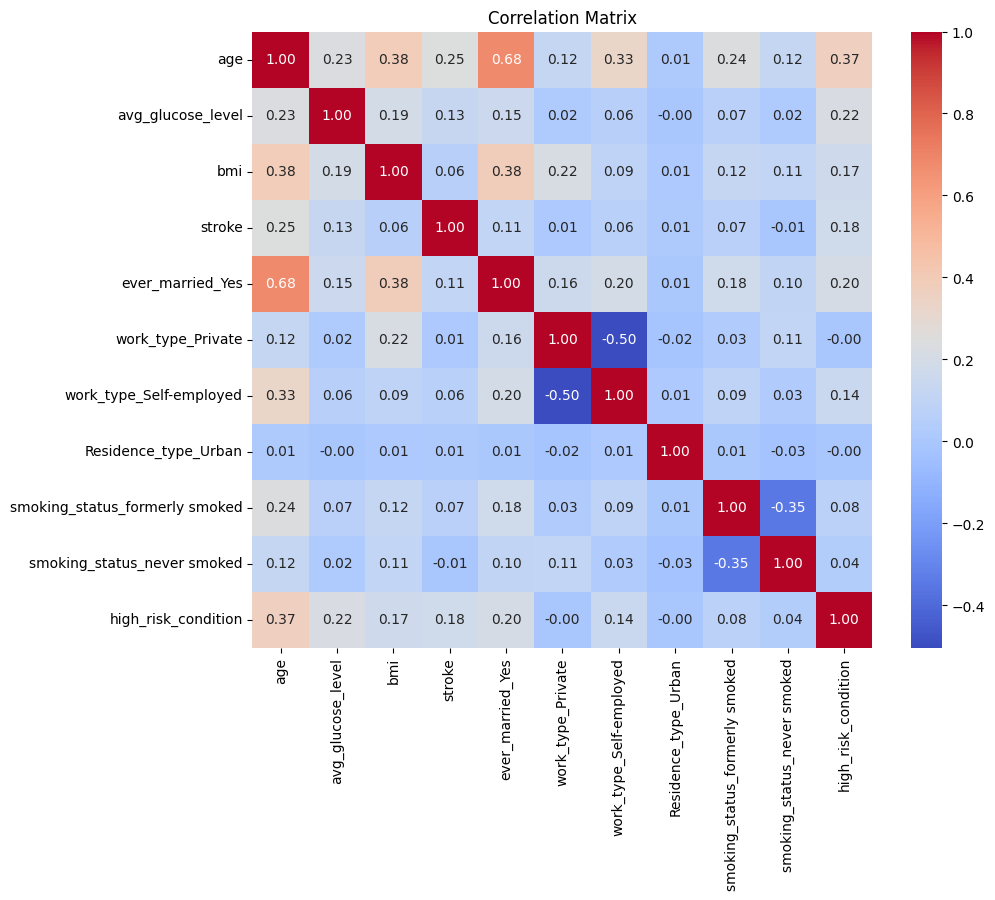

Categorical features: ['ever_married_Yes', 'work_type_Private', 'work_type_Self-employed', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'high_risk_condition']


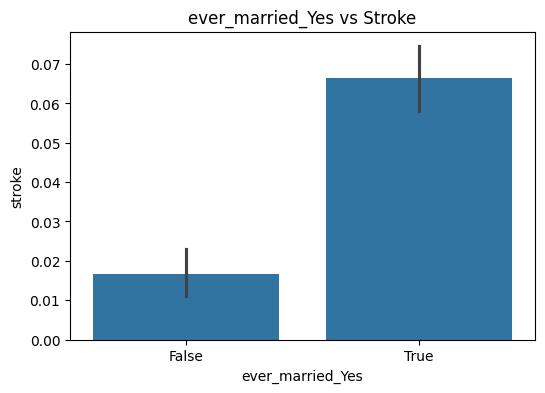

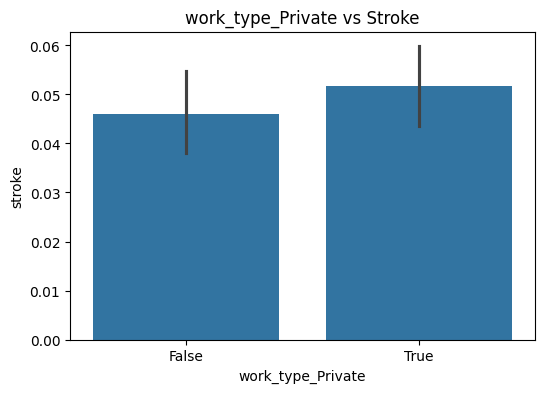

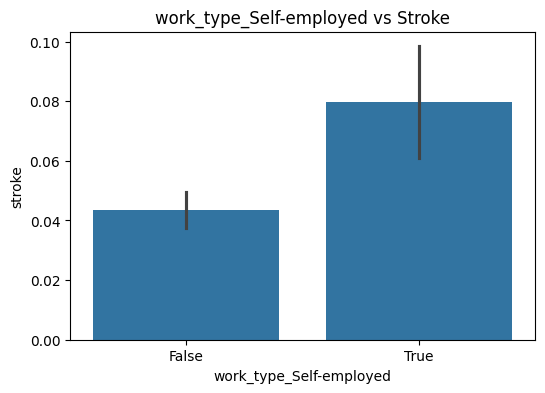

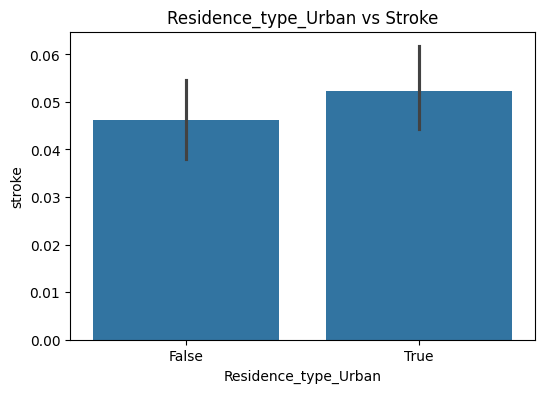

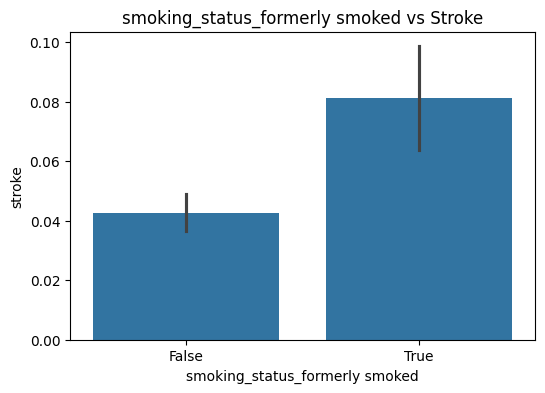

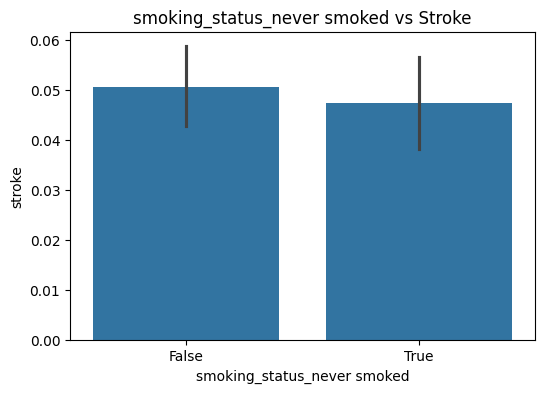

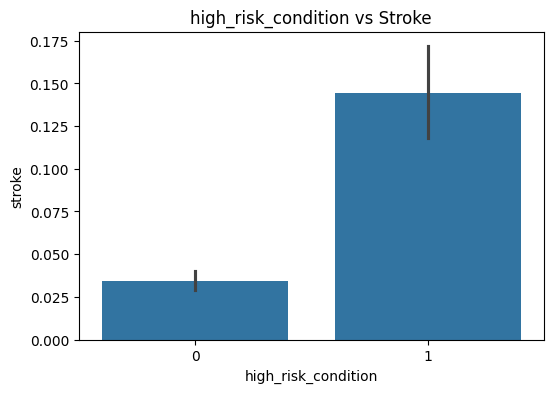

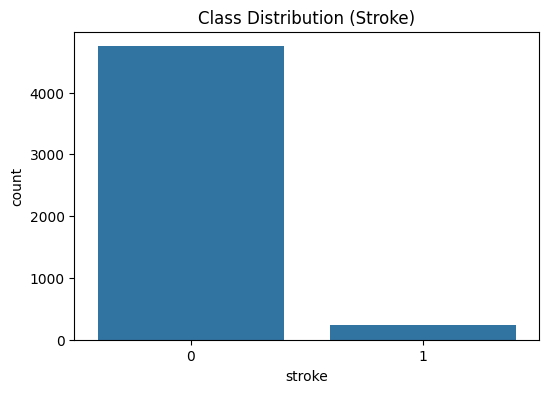

In [159]:
perform_eda(cleaned_data)

## Splitting and balancing data



In [160]:
import importlib
import src.model_training
importlib.reload(src.model_training)
from imblearn.over_sampling import ADASYN

X = cleaned_data.drop('stroke', axis=1)
y = cleaned_data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adasyn = ADASYN(random_state=42) 
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

print(f"Original training target distribution:\n{y_train.value_counts()}")
print(f"Resampled training target distribution:\n{pd.Series(y_train_resampled).value_counts()}")


Original training target distribution:
stroke
0    3808
1     186
Name: count, dtype: int64
Resampled training target distribution:
stroke
1    3810
0    3808
Name: count, dtype: int64


## Grid search (Logistic Regression and Random Forest)

In [161]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logistic_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

random_forest_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_grid = GridSearchCV(logistic_model, logistic_params, cv=5, scoring='roc_auc', n_jobs=-1)
logistic_grid.fit(X_train_resampled, y_train_resampled)

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_grid = GridSearchCV(random_forest_model, random_forest_params, cv=5, scoring='roc_auc', n_jobs=-1)
random_forest_grid.fit(X_train_resampled, y_train_resampled)

print("Best parameters for Logistic Regression:", logistic_grid.best_params_)
print("Best parameters for Random Forest:", random_forest_grid.best_params_)


Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## Combine the best models

In [162]:
best_logistic = logistic_grid.best_estimator_
best_random_forest = random_forest_grid.best_estimator_

voting_clf = VotingClassifier(
    estimators=[
        ('logistic', best_logistic),
        ('random_forest', best_random_forest)
    ],
    voting='soft'  
)

voting_clf.fit(X_train_resampled, y_train_resampled)

y_pred = voting_clf.predict(X_test)
y_scores = voting_clf.predict_proba(X_test)[:, 1]

print("Classification Report for Voting Classifier:\n")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score for Voting Classifier: {roc_auc_score(y_test, y_scores):.4f}")

Classification Report for Voting Classifier:

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       939
           1       0.18      0.55      0.28        60

    accuracy                           0.83       999
   macro avg       0.58      0.70      0.59       999
weighted avg       0.92      0.83      0.86       999

ROC AUC Score for Voting Classifier: 0.8249


## Optimising threshold

Optimal Threshold: 0.3749594100956984
[0.7709412  0.02789456 0.78212555 0.00240574 0.00197499 0.0222544
 0.01991156 0.03128166 0.36174593 0.02045305]
(array([0, 1]), array([713, 286]))
Evaluation with Optimized Threshold:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       939
           1       0.17      0.80      0.28        60

    accuracy                           0.75       999
   macro avg       0.58      0.77      0.56       999
weighted avg       0.93      0.75      0.81       999



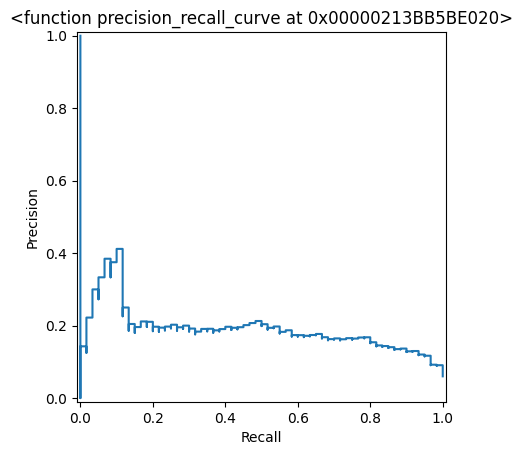

stroke
0    939
1     60
Name: count, dtype: int64
stroke
1    3810
0    3808
Name: count, dtype: int64
[[0.2290588  0.7709412 ]
 [0.97210544 0.02789456]
 [0.21787445 0.78212555]
 [0.99759426 0.00240574]
 [0.99802501 0.00197499]
 [0.9777456  0.0222544 ]
 [0.98008844 0.01991156]
 [0.96871834 0.03128166]
 [0.63825407 0.36174593]
 [0.97954695 0.02045305]]
Confusion Matrix with Optimized Threshold:
[[701 238]
 [ 12  48]]
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       939
           1       0.17      0.80      0.28        60

    accuracy                           0.75       999
   macro avg       0.58      0.77      0.56       999
weighted avg       0.93      0.75      0.81       999

Default Threshold (0.5):
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       939
           1       0.18      0.55      0.28        60

    accuracy                           0.83       999
   macro 

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)


optimal_threshold = thresholds[np.argmax(precision * recall)]
print(f"Optimal Threshold: {optimal_threshold}")

y_pred_adjusted = (y_scores >= optimal_threshold).astype(int)
print(y_scores[:10])
print(np.unique(y_pred_adjusted, return_counts=True))

print("Evaluation with Optimized Threshold:")
print(classification_report(y_test, y_pred_adjusted))
PrecisionRecallDisplay(precision=precision,recall=recall).plot()
plt.title('Precision-Recall Curve')  
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()
print(y_test.value_counts())
print(y_train_resampled.value_counts())
print(voting_clf.predict_proba(X_test)[:10])
print("Confusion Matrix with Optimized Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))


print(classification_report(y_test, y_pred_adjusted))
print("Default Threshold (0.5):")
print(classification_report(y_test, y_pred))

print("Optimized Threshold:")
print(classification_report(y_test, y_pred_adjusted))

## Checking feature importance
 
Used earlier for removal of features with low importance 

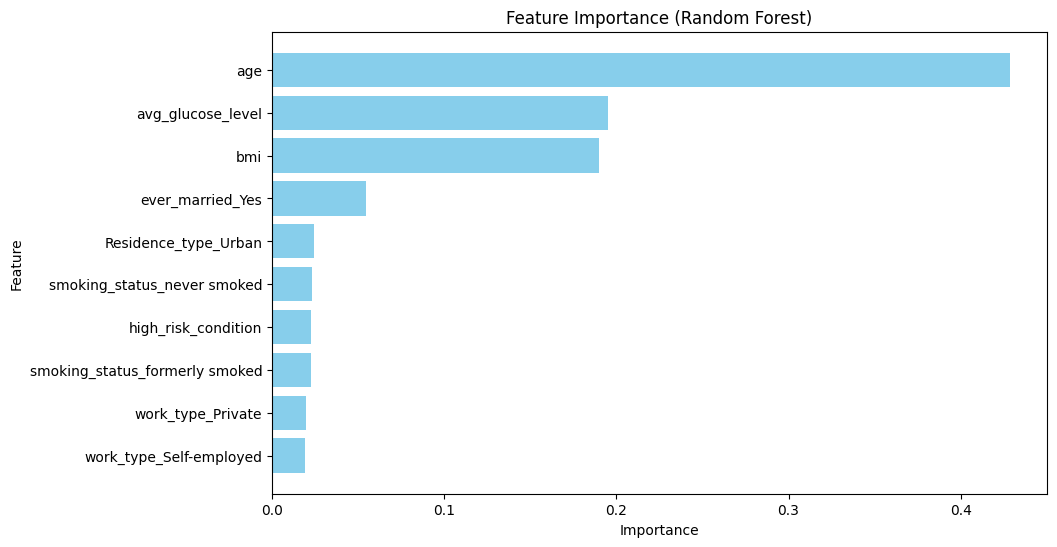

                          Feature  Importance
0                             age    0.428687
1               avg_glucose_level    0.195130
2                             bmi    0.189804
3                ever_married_Yes    0.054403
6            Residence_type_Urban    0.024544
8     smoking_status_never smoked    0.023281
9             high_risk_condition    0.022696
7  smoking_status_formerly smoked    0.022519
4               work_type_Private    0.019514
5         work_type_Self-employed    0.019422


In [164]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

feature_importances = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

print(feature_importances)

## Evaluate the Model



In [165]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_with_threshold(y_test, y_scores, optimal_threshold):
    y_pred_adjusted = (y_scores >= optimal_threshold).astype(int)
    
    print("Evaluation with Optimized Threshold:")
    print(classification_report(y_test, y_pred_adjusted))

evaluate_with_threshold(y_test, y_scores, optimal_threshold)

Evaluation with Optimized Threshold:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       939
           1       0.17      0.80      0.28        60

    accuracy                           0.75       999
   macro avg       0.58      0.77      0.56       999
weighted avg       0.93      0.75      0.81       999



## Step 6: Interpret the Model

Finally, we will interpret the model's predictions using the `interpret_model` function.

<class 'pandas.core.frame.DataFrame'>
age                               float64
avg_glucose_level                 float64
bmi                               float64
ever_married_Yes                     bool
work_type_Private                    bool
work_type_Self-employed              bool
Residence_type_Urban                 bool
smoking_status_formerly smoked       bool
smoking_status_never smoked          bool
high_risk_condition                 int64
dtype: object
Interpreting model: Logistic Regression


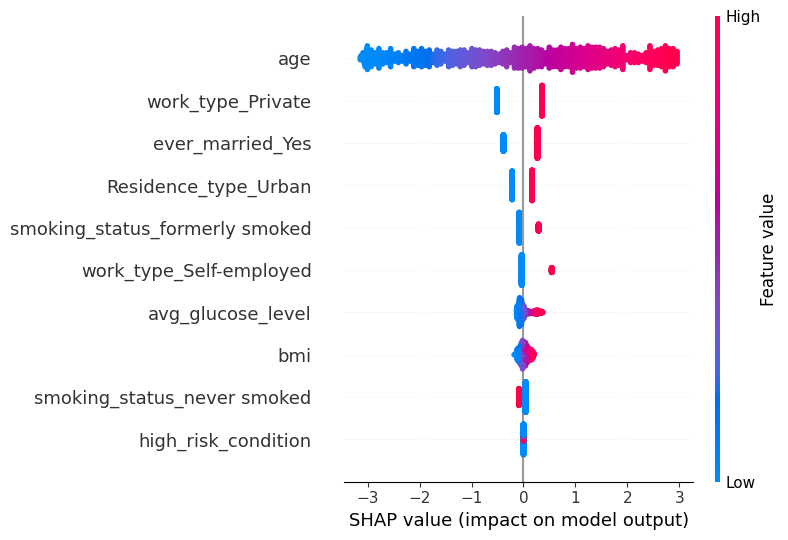

Interpreting model: Random Forest


 99%|===================| 1981/1998 [01:09<00:00]        

<Figure size 640x480 with 0 Axes>

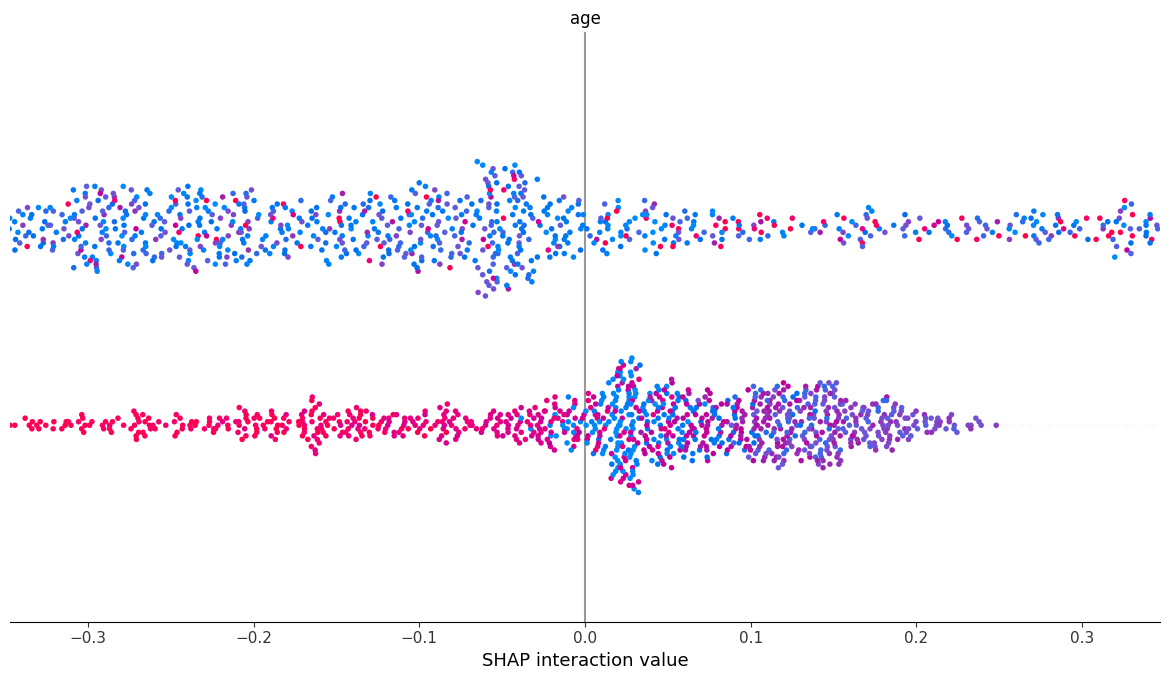

In [168]:
import shap
print(type(X_test))
print(X_test.dtypes)
X_test = X_test.astype({col: 'float' for col in X_test.select_dtypes(include=['bool']).columns})
def interpret_individual_model(model, X_test, model_name):
    print(f"Interpreting model: {model_name}")
    
    explainer = shap.Explainer(model, X_test)
    
    shap_values = explainer(X_test)
    
    shap.summary_plot(shap_values, X_test)

interpret_individual_model(voting_clf.named_estimators_['logistic'], X_test, "Logistic Regression")

interpret_individual_model(voting_clf.named_estimators_['random_forest'], X_test, "Random Forest")